## Determining best trades using Reinforcement Learning

The goal is to implement a trading strategy that determines which trades to execute using Reinforcement Learning. This notebook will implement a model using Sharpe's ratio for maximising the reward function. 

Based on Gabriel Molina's paper, [Stock Trading with Recurrent Reinforcement Learning (RRL)](http://cs229.stanford.edu/proj2006/Molina-StockTradingWithRecurrentReinforcementLearning.pdf).

###Setup - we need to define:
1. A function to determine position at a given time - Trader function
2. Returns function
3. Function for measuring performance of the investments - Sharpe ratio

## 1. Trader Function

Here, we define a function that determines our position on an asset.

The input to the trading strategy will be a time series of changes to the asset price. Formally, input vector $x _t$ is defined as:

$x_t = [1, r_{t - M}, ... , r_t, F_{t - 1}] $

$r_t$ = % change between the asset at time $t$ and $t - 1$

$M$ = is the number of time periods of the historical asset price data used as input.

$F _t$ is the position at time $t$ which is defined as:

$$F _t = \tanh(\theta^T x _t)$$

This function $F _t$ which will generate a value between 0 and 1, indicating what percentage of the portfolio should buy the asset.

$\theta$ are the parameters that will be optimized using gradient ascent.

Hence the model is being contains historical price changes and the last position on the asset to calculate the next position.

Function to calculate all of the positions given price series `x`, and `theta`:

In [1]:
import numpy as np

def positions(x, theta):
    M = len(theta) - 2
    T = len(x)
    Ft = np.zeros(T)
    for t in range(M, T):  # start computing positions from time M
        previous_prices = x[(t - M):t]
        last_position = Ft[t - 1]
        xt = np.concatenate([[1], previous_prices, [last_position]])
        Ft[t] = np.tanh(np.dot(theta, xt))
    return Ft

## 2. Calculating Returns

Based on the positions at each time step, we calculate our returns $R$ using the following formula:

$$R _t = F _{t-1}r _t - \delta | F _t - F _{t - 1}| $$

Here, $\delta$ is the transaction cost rate. 

Returns function:

In [2]:
def returns(Ft, x, delta):
    T = len(x)
    transaction_penalty = delta * np.abs(Ft[1:T] - Ft[0:T - 1])
    returns_from_last_decision = Ft[0:T - 1] * x[1:T]
    
    rets = returns_from_last_decision - transaction_penalty
    return np.concatenate([[0], rets])

## 3. Performance of the returns: Sharpe Ratio

To measure the risk-adjusted performance of an investment over time, we compute the Sharpe ratio. For the time series of investment returns $R _T$ defined in the previous step, the Sharpe ratio is computed as:

$$S _T = {Mean(R _T) \over StdDev(R _T)}$$

For simplicity, this assumes a risk-free rate of 0.

Defining a function for computing the Shape ratio:

In [3]:
def sharpe_ratio(returns):
    return returns.mean() / returns.std()

# Gradient Ascent

## Determining the Gradient

In order to perform gradient ascent, we must compute the derivative of the Sharpe ratio with respect to theta, or ${dS _T}\over{d\theta}$ Using the chain rule and the above formulas we can write it as:

$${{dS _T}\over{d\theta}} = \sum\limits_{t=1}^{T} ( {{dS _T}\over{dA}}{{dA}\over{dR _t}} + {{dS _T}\over{dB}}{{dB}\over{dR _t}}) \cdot ({{dR _t}\over{dF _t}}{{dF}\over{d\theta}} + {{dR _t}\over{dF _{t-1}}}{{dF _{t-1}}\over{d\theta}})$$

We can compute this derivative in our `gradient` function:

In [4]:
def gradient(x, theta, delta):
    Ft = positions(x, theta)
    rets = returns(Ft, x, delta)
    T = len(x)
    M = len(theta) - 2
    S = sharpe_ratio(rets)

    grad = np.zeros(M + 2)  # initialize gradient
    p_dF_dTheta = np.zeros(M + 2)  # previous dF_dTheta
    
    for t in range(M, T):
        xt = np.concatenate([[1], x[t - M:t], [Ft[t-1]]])
        dR_dF = -delta * np.sign(Ft[t] - Ft[t-1])
        dR_dFp = x[t] + delta * np.sign(Ft[t] - Ft[t-1])
        dF_dTheta = (1 - Ft[t] ** 2) * (xt + theta[-1] * p_dF_dTheta)
        dS_dTheta = (dR_dF * dF_dTheta + dR_dFp * p_dF_dTheta)
        grad = grad + dS_dTheta
        p_dF_dTheta = dF_dTheta
        
    return grad, S

## Training

Now optimize the parameters $\theta$ using gradient ascent.

$\theta$ is updated after each epoch using $\theta = \theta + \alpha{dS _T \over d\theta}$, where $\alpha$ is the learning rate.

In [32]:
def train(x, epochs=500, M=5, transaction_penalty=0.0025, learning_rate = 0.001):
    theta = np.ones(M + 2)
    sharpes = np.zeros(epochs) # store sharpes over time
    for i in range(epochs):
        grad, sharpe = gradient(x, theta, transaction_penalty)
        theta = theta + grad * learning_rate
        sharpes[i] = sharpe
    
    print("finished training")
    return theta, sharpes

# Reinforcement learning on data

To test the model, we use historical citi group data, minute frequency. 

In [25]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

%matplotlib inline
plt.rcParams["figure.figsize"] = (5, 3) # (w, h)
plt.rcParams["figure.dpi"] = 200

sd = [datetime(2021, 3, 20), datetime(2021, 3, 27), datetime(2021, 4, 3), datetime(2021, 4, 10)]  
ed = [datetime(2021, 3, 27), datetime(2021, 4, 3), datetime(2021, 4, 10), datetime(2021, 4, 15)]
fut = pd.DataFrame(columns=["Adj Close","Volume"])

for i in range(len(sd)):
    df = yf.download('c', start=sd[i], end = ed[i], interval='1m')[['Adj Close','Volume']]
    fut = fut.append(df, ignore_index = False)
rets = fut['Adj Close'].diff()[1:]
rets

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


2021-03-22 09:31:00-04:00   -0.080002
2021-03-22 09:32:00-04:00   -0.099998
2021-03-22 09:33:00-04:00   -0.070000
2021-03-22 09:34:00-04:00   -0.044998
2021-03-22 09:35:00-04:00   -0.334999
                               ...   
2021-04-14 15:55:00-04:00    0.000603
2021-04-14 15:56:00-04:00    0.110001
2021-04-14 15:57:00-04:00    0.019997
2021-04-14 15:58:00-04:00    0.055000
2021-04-14 15:59:00-04:00    0.020004
Name: Adj Close, Length: 6623, dtype: float64

For this strategy we will train the model on 1000 samples, and then trade on the next 200 samples. 

Normalize the data, and split it into training and test data:

In [54]:
x = np.array(rets)
x = (x - np.mean(x)) / np.std(x) # normalize

N = 500
P = 25
x_train = x[-(N+P):-P]
x_test = x[-P:]

Training with a look-back window of 5.

In [55]:
theta, sharpes = train(x_train, epochs=900, M=5, transaction_penalty=0.0025, learning_rate=.001)

finished training


In order to see how well the training did, we can graph the resulting Sharpe ratio over each epoch, and hopefully see it converge to a maximum.

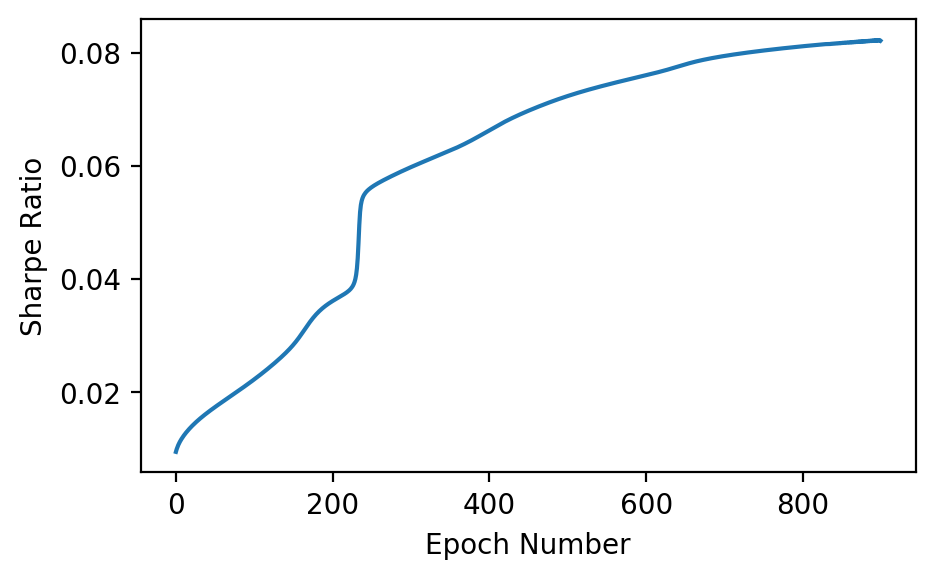

In [56]:
plt.plot(sharpes)
plt.xlabel('Epoch Number')
plt.ylabel('Sharpe Ratio');

We can see that as the model trains, it converges towards a maximum Sharpe Ratio. Lets see how the model performed over the training data:

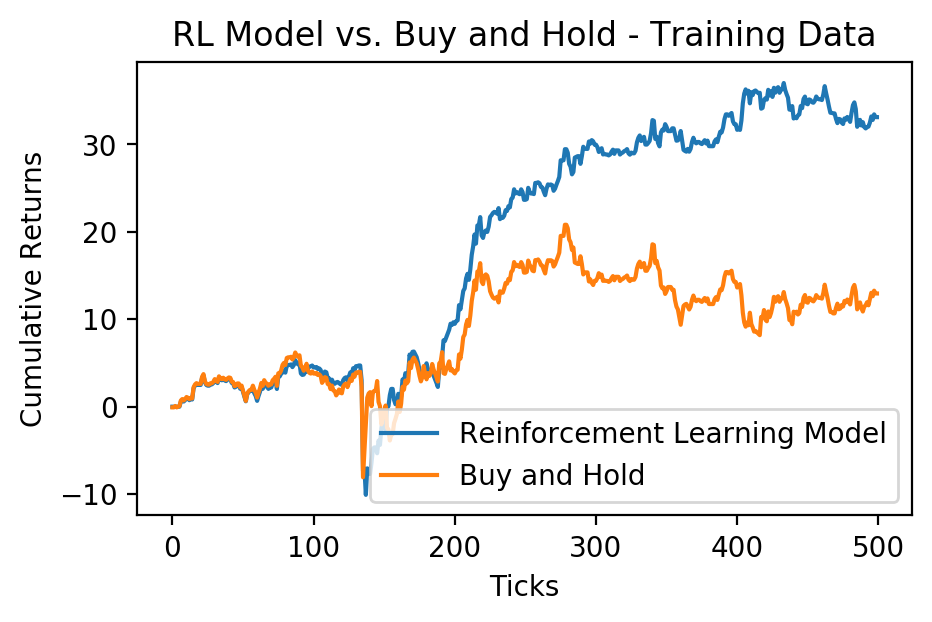

In [57]:
train_returns = returns(positions(x_train, theta), x_train, 0.0025)
plt.plot((train_returns).cumsum(), label="Reinforcement Learning Model")
plt.plot(x_train.cumsum(), label="Buy and Hold")
plt.xlabel('Ticks')
plt.ylabel('Cumulative Returns');
plt.legend()
plt.title("RL Model vs. Buy and Hold - Training Data");

The reinforcement learning model greatly outperforms simply buying and holding the asset over the training data. But does it perform well on the test data?

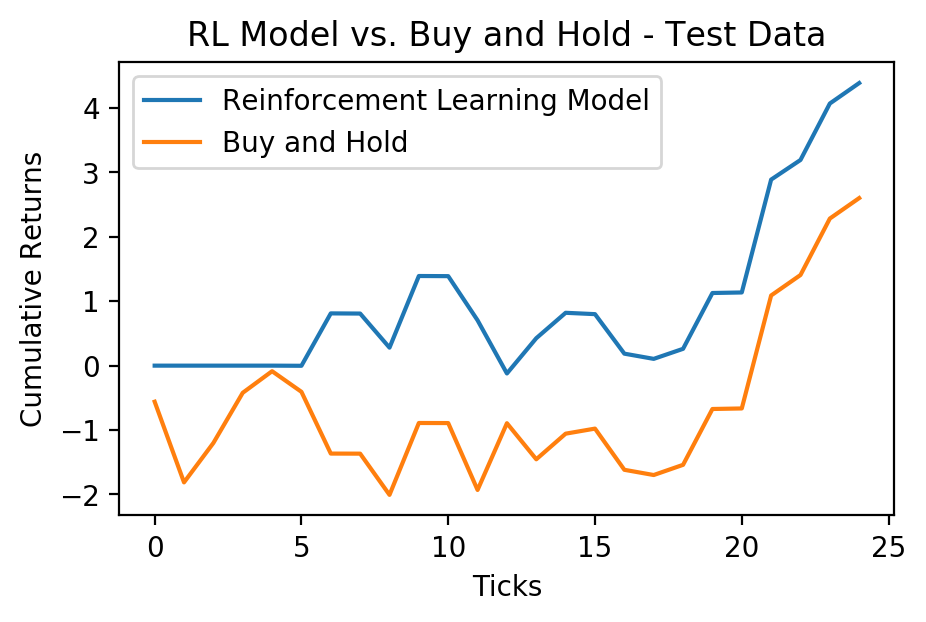

In [58]:
test_returns = returns(positions(x_test, theta), x_test, 0.0025)
plt.plot((test_returns).cumsum(), label="Reinforcement Learning Model")
plt.plot(x_test.cumsum(), label="Buy and Hold")
plt.xlabel('Ticks')
plt.ylabel('Cumulative Returns');
plt.legend()
plt.title("RL Model vs. Buy and Hold - Test Data");

The reinforcement model performs slightly better than the simple buy and hold strategy in the test data